<a href="https://colab.research.google.com/github/EuroLifeWay/Project-pairs-trading/blob/main/Pair_Trading_universal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="whitegrid")

# pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas as pd
# from pandas_datareader import data as pdr  #
import pandas_datareader as pdr
import yfinance as yf
# yf.pdr_override()

print("Pandas version:", pd.__version__)

Pandas version: 2.2.2


### Data Science in Trading

Before we begin, I’ll first define a function that makes it easy to find cointegrated security pairs using the concepts we’ve already covered.

Прежде чем мы начнем, я сначала определю функцию, которая облегчает поиск коинтегрированных пар ценных бумаг с помощью уже рассмотренных нами концепций.

In [3]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

We are looking through a set of tech companies to see if any of them are cointegrated. We'll start by defining the list of securities we want to look through. Then we'll get the pricing data for each security from the year 2013 - 2018..

As mentioned before, we have formulated an economic hypothesis that there is some sort of link between a subset of securities within the tech sector and we want to test whether there are any cointegrated pairs. This incurs significantly less multiple comparisons bias than searching through hundreds of securities and slightly more than forming a hypothesis for an individual test.

Мы изучаем набор технологических компаний, чтобы выяснить, есть ли среди них коинтегрированные. Для начала определим список ценных бумаг, которые мы хотим просмотреть. Затем мы получим данные о ценах на каждую ценную бумагу за период с 2013 по 2018 год.

Как уже говорилось, мы сформулировали экономическую гипотезу о существовании некой связи между подмножеством ценных бумаг в технологическом секторе и хотим проверить, есть ли среди них коинтегрированные пары. Это дает значительно меньше ошибок множественных сравнений, чем поиск по сотням ценных бумаг, и чуть больше, чем формирование гипотезы для отдельного теста.

In [4]:
import datetime
import yfinance as yf

start = datetime.datetime(2017, 1, 1)
end = datetime.datetime.now()

tickers = ['EURAUD=X', 'AUDCHF=X', 'EURUSD=X', 'GBPUSD=X', 'AUDJPY=X', 'NZDCHF=X']
# tickers = ['ES=F', 'SPY', 'NQ=F', 'QQQ', 'YM=F', 'YMAX', '^DJI', 'DJIA', '^RUT', 'IWM']
# tickers = ['ES=F', 'NQ=F']
# tickers = ['AAPL', 'ADBE', 'ORCL', 'EBAY', 'MSFT', 'QCOM', 'HPQ', 'JNPR', 'AMD', 'IBM',
#            'SPY', '^GSPC', '^SPX', '^IXIC', '^NDX', '^DJI', '^RUT', 'CL=F', 'GC=F', 'ES=F', 'NQ=F', 'QQQ', 'YM=F', 'YMAX', 'DJIA', 'IWM']

# ====================
# # Заданные таймфреймы (интервалы)
# intervals = ['1d', '1h', '90m', '15m', '5m', '3m', '1m']
interval = '5m'

# Словарь с максимальными периодами для каждого интервала,
# с учетом ограничений yfinance.
# 1m = 7 дней, остальные внутридневные (<1d) = 60 дней, дневные (>=1d) = max
max_periods = {
    '1d': 'max',
    '1h': '60d',
    '90m': '60d',
    '15m': '60d',
    '5m': '60d',
    '3m': '60d',
    '1m': 'max'#'8d'
}

period = max_periods[interval]

# Загрузка данных с yfinance
df = yf.download(tickers, period=period, interval=interval, progress=False, auto_adjust=False)['Close']#, auto_adjust=False)
# ====================

# Загружаем данные через yfinance
# df = yf.download(tickers, start=start, end=end)['Close']
df.tail()

Ticker,AUDCHF=X,AUDJPY=X,EURAUD=X,EURUSD=X,GBPUSD=X,NZDCHF=X
Datetime,,,,,,
2025-08-07 20:20:00+00:00,0.52579,95.905998,1.78809,1.167133,1.344755,0.48042
2025-08-07 20:25:00+00:00,0.52568,95.904999,1.78853,1.167406,1.344899,0.48036
2025-08-07 20:30:00+00:00,0.52589,95.938004,1.78745,1.166725,1.344357,0.48055
2025-08-07 20:35:00+00:00,0.52585,95.941002,1.78785,1.166725,1.344375,0.48051
2025-08-07 20:40:00+00:00,0.52581,95.942001,1.78799,1.166861,1.344483,0.48048


In [273]:
# df = full_data
# print(df)

In [5]:
len_df = len(df)
# len_df = len(full_df)
print(f'len(df): {len_df}')
print(f'5m в сутках: {22*60/5}')
print(f'Дней в df_len: {len_df / (22*60/5)}')
# # print(f'1m в сутках: {22*60}')
# print(f'Дней в df_len: {len_df / (22*60)}')

len(df): 17030
5m в сутках: 264.0
Дней в df_len: 64.50757575757575


1. Проверка на наличие NaN значений

Чтобы быстро найти строки с недопустимыми значениями, используйте методы DataFrame:

In [6]:
# Проверка на наличие NaN значений
print(df.isna().sum())  # Выводит количество NaN в каждом столбце

Ticker
AUDCHF=X     4
AUDJPY=X     3
EURAUD=X     3
EURUSD=X    23
GBPUSD=X    19
NZDCHF=X     3
dtype: int64


In [7]:
# Или для поиска строк, содержащих хотя бы одно значение NaN
nan_rows = df[df.isna().any(axis=1)]
print(nan_rows)  # Печатает строки с NaN

Ticker                     AUDCHF=X   AUDJPY=X  EURAUD=X  EURUSD=X  GBPUSD=X  \
Datetime                                                                       
2025-05-28 21:35:00+00:00   0.53112  92.968002   1.75678       NaN       NaN   
2025-05-28 21:40:00+00:00   0.53111  92.952003   1.75685       NaN       NaN   
2025-05-28 21:50:00+00:00   0.53111  92.978996   1.75762       NaN       NaN   
2025-05-29 06:35:00+00:00   0.53502  93.689003   1.75109       NaN       NaN   
2025-06-05 07:15:00+00:00   0.53287  93.132004   1.75508       NaN       NaN   
2025-06-06 15:20:00+00:00   0.53403  93.976997   1.75567       NaN       NaN   
2025-06-06 15:25:00+00:00   0.53396  94.010002   1.75571       NaN       NaN   
2025-06-06 15:30:00+00:00   0.53376  93.996002   1.75558       NaN       NaN   
2025-06-06 15:40:00+00:00   0.53362  94.031998   1.75534       NaN       NaN   
2025-06-09 06:15:00+00:00   0.53427  93.971001   1.75382       NaN       NaN   
2025-06-10 15:10:00+00:00   0.53644  94.

2. Проверка на наличие бесконечных значений

Чтобы проверить наличие бесконечных значений (inf и -inf), используйте метод isinf():

In [8]:
import numpy as np

# Проверка на строки, содержащие inf или -inf
inf_rows = df[~np.isfinite(df).all(axis=1)]

# # Проверка на бесконечные значения
# inf_rows = df[~df.isfinite().all(axis=1)]
print(inf_rows)  # Печатает строки с inf

Ticker                     AUDCHF=X   AUDJPY=X  EURAUD=X  EURUSD=X  GBPUSD=X  \
Datetime                                                                       
2025-05-28 21:35:00+00:00   0.53112  92.968002   1.75678       NaN       NaN   
2025-05-28 21:40:00+00:00   0.53111  92.952003   1.75685       NaN       NaN   
2025-05-28 21:50:00+00:00   0.53111  92.978996   1.75762       NaN       NaN   
2025-05-29 06:35:00+00:00   0.53502  93.689003   1.75109       NaN       NaN   
2025-06-05 07:15:00+00:00   0.53287  93.132004   1.75508       NaN       NaN   
2025-06-06 15:20:00+00:00   0.53403  93.976997   1.75567       NaN       NaN   
2025-06-06 15:25:00+00:00   0.53396  94.010002   1.75571       NaN       NaN   
2025-06-06 15:30:00+00:00   0.53376  93.996002   1.75558       NaN       NaN   
2025-06-06 15:40:00+00:00   0.53362  94.031998   1.75534       NaN       NaN   
2025-06-09 06:15:00+00:00   0.53427  93.971001   1.75382       NaN       NaN   
2025-06-10 15:10:00+00:00   0.53644  94.

3. Удаление или заполнение NaN и inf значений

После того как вы определили строки с NaN или inf значениями, вы можете удалить их или заполнить:

* Удаление строк с NaN:

In [9]:
df_cleaned = df.dropna()  # Удаляет все строки с хотя бы одним NaN

* Заполнение NaN:

In [266]:
# df_filled = df.fillna(0)  # Заполняет все NaN нулями (вы можете использовать другое значение)

* Удаление строк с inf:

In [10]:
df_cleaned_inf = df[~df.isin([np.inf, -np.inf]).any(axis=1)]  # Оставляет только строки без inf

Проверка данных после очистки

После удаления или заполнения недопустимых значений, лучше проверить ваш DataFrame снова:

In [11]:
print(df_cleaned.isna().sum())  # Убедитесь, что нет NaN
print((df_cleaned.isin([np.inf, -np.inf])).sum())  # Убедитесь, что нет inf

Ticker
AUDCHF=X    0
AUDJPY=X    0
EURAUD=X    0
EURUSD=X    0
GBPUSD=X    0
NZDCHF=X    0
dtype: int64
Ticker
AUDCHF=X    0
AUDJPY=X    0
EURAUD=X    0
EURUSD=X    0
GBPUSD=X    0
NZDCHF=X    0
dtype: int64


In [12]:
df = df_cleaned

In [13]:
len_df_cleaned = len(df)
# len_df = len(full_df)
print(f'len(df): {len_df_cleaned}')
print(f'5m в сутках: {22*60/5}')
print(f'Дней в df_len: {len_df_cleaned / (22*60/5)}')
# # print(f'1m в сутках: {22*60}')
# print(f'Дней в df_len: {len_df / (22*60)}')

len(df): 17006
5m в сутках: 264.0
Дней в df_len: 64.41666666666667


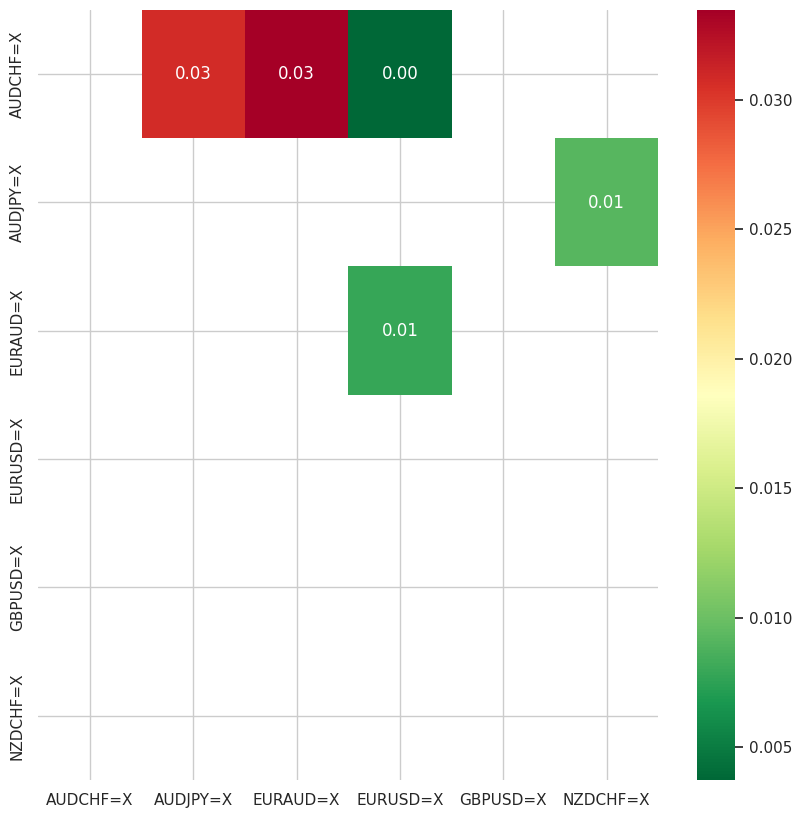

[('AUDCHF=X', 'AUDJPY=X'), ('AUDCHF=X', 'EURAUD=X'), ('AUDCHF=X', 'EURUSD=X'), ('AUDJPY=X', 'NZDCHF=X'), ('EURAUD=X', 'EURUSD=X')]


In [14]:
# Heatmap to show the p-values of the cointegration test between each pair of
# stocks. Only show the value in the upper-diagonal of the heatmap
scores, pvalues, pairs = find_cointegrated_pairs(df)
# import seaborn
# fig, ax = plt.subplots(figsize=(10,10))
# seaborn.heatmap(pvalues, xticklabels=tickers, yticklabels=tickers, cmap='RdYlGn_r'
#                 , mask = (pvalues >= 0.05)
#                 )

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Предполагаю, что у вас есть список тикеров
tickers = df.columns.tolist()  # или ваш список тикеров

# Предполагаю, что pvalues — это массив numpy (n x n)
# и его порядок соответствует tickers

# Создайте DataFrame из pvalues с индексами и колонками = tickers
pvalues_df = pd.DataFrame(pvalues, index=tickers, columns=tickers)

# Построение heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(
    pvalues_df,
    xticklabels=tickers,
    yticklabels=tickers,
    cmap='RdYlGn_r',
    mask=(pvalues_df >= 0.05),
    annot=True,  # если хотите отображать значения
    fmt=".2f"
)
plt.show()

print(pairs)

Our algorithm listed two pairs that are cointegrated: AAPL/EBAY, and ADBE/MSFT. We can analyze their price patterns to make sure there is nothing weird going on.

Наш алгоритм указал две пары, которые являются коинтегрированными: AAPL/EBAY и ADBE/MSFT. Мы можем проанализировать их ценовые модели, чтобы убедиться, что ничего странного не происходит.

In [22]:
pair = 2 # Выбираем пару по номеру списка выше
names = pairs[pair]
print(names)
S1, S2 = np.log(df[names[0]]), np.log(df[names[1]])
# S1, S2 = np.log(df[names[0]].replace(0, np.nan)), np.log(df[names[1]].replace(0, np.nan))
# epsilon = 1e-10
# S1, S2 = np.log(df[names[0]] + epsilon), np.log(df[names[1]] + epsilon)
# S1 = df['NQ=F']
# S2 = df['QQQ']

score, pvalue, _ = coint(S1, S2)
# pvalue
print(f'P-value: {pvalue:.7f}')
# S1.tail()

('AUDCHF=X', 'EURUSD=X')
P-value: 0.0036592


In [26]:
pair = 2 # Выбираем пару по номеру списка выше
names = pairs[pair]
print(names)
S1, S2 = df[names[0]], df[names[1]]
# S1 = df['NQ=F']
# S2 = df['QQQ']

score, pvalue, _ = coint(S1, S2)
# pvalue
print(f'P-value: {pvalue:.7f}')
# S1.tail()

('AUDCHF=X', 'EURUSD=X')
P-value: 0.0037336


In [16]:
# S1 = df['EURUSD=X']
# S2 = df['GBPUSD=X']

# score, pvalue, _ = coint(S1, S2)
# pvalue

In [20]:
# S1 = df['AUDCHF=X']
# S2 = df['NZDCHF=X']

# score, pvalue, _ = coint(S1, S2)
# pvalue

np.float64(0.004030969836152772)

As we can see, the p-value is less than 0.05, which means ADBE and MSFT are indeed cointegrated pairs.

Как мы видим, p-значение меньше 0,05, что означает, что ADBE и MSFT действительно являются коинтегрированными парами.

#### Calculating the Spread

Now we can plot the spread of the two time series. In order to actually calculate the spread, we use a linear regression to get the coefficient for the linear combination to construct between our two securities, as mentioned with the Engle-Granger method before.

Теперь мы можем построить график спреда двух временных рядов. Для того чтобы рассчитать спред, мы используем линейную регрессию, чтобы получить коэффициент для линейной комбинации, которую мы построим между нашими двумя ценными бумагами, как уже упоминалось в методе Энгла-Грейнджера.

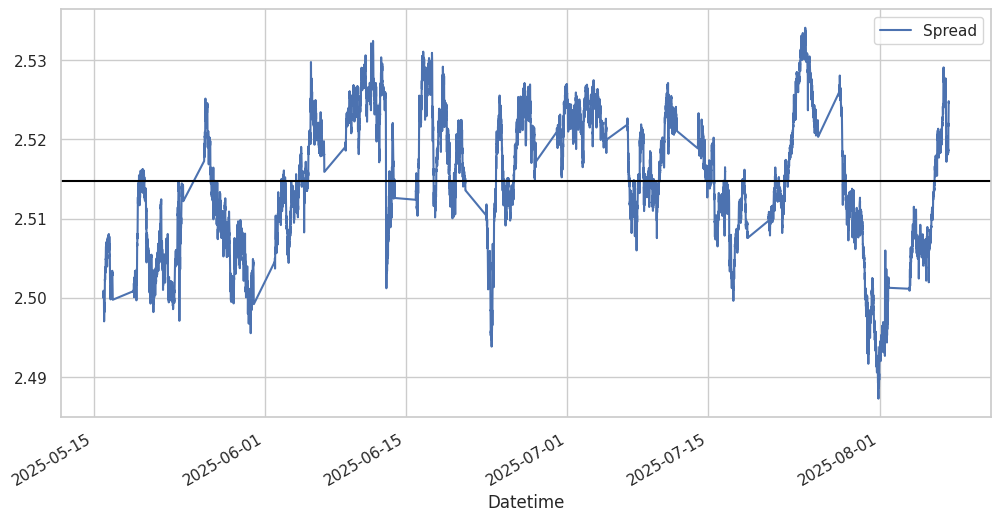

In [27]:
S1 = sm.add_constant(S1)
results = sm.OLS(S2, S1).fit()
# S1 = S1['NQ=F']
# b = results.params['NQ=F']
S1 = S1[names[0]]
b = results.params[names[0]]

spread = S2 - b * S1
spread.plot(figsize=(12,6))
plt.axhline(spread.mean(), color='black')
# plt.xlim('2019-01-01', datetime.datetime.now())
# end_date = df.index.max()
# start_date = end_date - pd.Timedelta(period)
# plt.xlim(start_date, datetime.datetime.now())
plt.legend(['Spread']);

Alternatively, we can examine the ration between the two time series

В качестве альтернативы мы можем изучить соотношение между двумя временными рядами

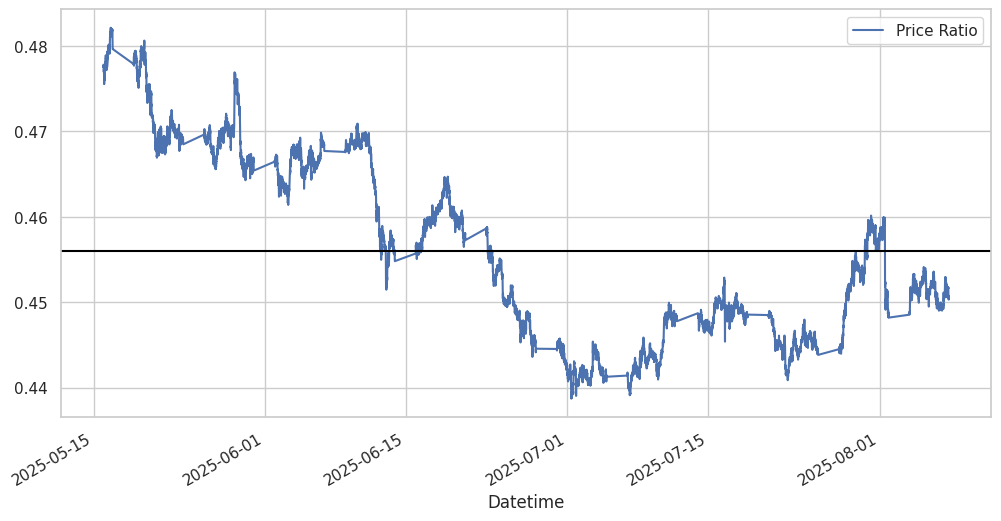

In [28]:
ratio = S1/S2
ratio.plot(figsize=(12,6))
plt.axhline(ratio.mean(), color='black')
# plt.xlim('2019-01-01', datetime.datetime.now())
# end_date = df.index.max()
# start_date = end_date - pd.Timedelta(period)
# plt.xlim(start_date, datetime.datetime.now())
plt.legend(['Price Ratio']);

Regardless of whether or not we use the spread approach or the ratio approach, we can see that our first plot pair ADBE/MSFT tends to move around the mean. We now need to standardize this ratio because the absolute ratio might not be the most ideal way of analyzing this trend. For this, we need to use z-scores.

A z-score is the number of standard deviations a datapoint is from the mean. More importantly, the nmber of standard deviations above or below the population mean is from the raw score. The z-score is calculated by the follow:

Независимо от того, используем ли мы подход спреда или подход соотношения, мы видим, что наша первая пара ADBE/MSFT имеет тенденцию двигаться вокруг среднего значения. Теперь нам нужно стандартизировать это соотношение, потому что абсолютное соотношение может быть не самым идеальным способом анализа этой тенденции. Для этого нам нужно использовать z-скор.

z-score - это количество стандартных отклонений точки данных от среднего значения. Что еще более важно, это количество стандартных отклонений выше или ниже среднего значения популяции от исходного балла. z-скор рассчитывается следующим образом:

$$\mathcal{z}_{i}=\frac{x_{i}-\bar{x}}{s} $$

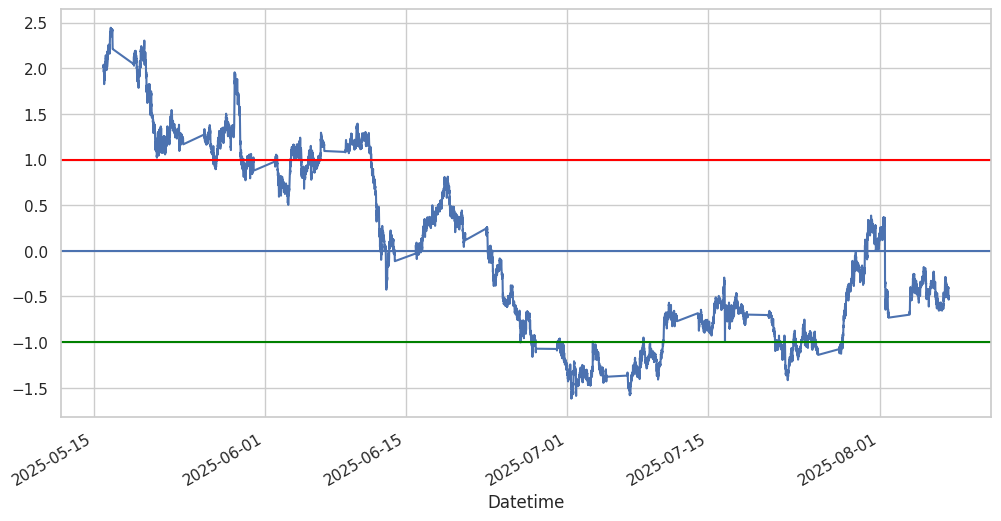

In [29]:
def zscore(series):
    return (series - series.mean()) / np.std(series)


zscore(ratio).plot(figsize=(12,6))
plt.axhline(zscore(ratio).mean())
plt.axhline(1.0, color='red')
plt.axhline(-1.0, color='green')
# plt.xlim('2019-01-01', datetime.datetime.now())
# plt.xlim('2025-07-06', datetime.datetime.now())
#
# end_date = df.index.max()
# start_date = end_date - pd.Timedelta(period)
# plt.xlim(start_date, datetime.datetime.now())
#
plt.show()

By setting two other lines placed at the z-score of 1 and -1, we can clearly see that for the most part, any big divergences from the mean eventually converges back. This is exactly what we want for a pairs trading strategy.

Проведя еще две линии, расположенные на z-score 1 и -1, мы можем четко видеть, что в большинстве случаев любые большие отклонения от среднего значения в конечном итоге сходятся обратно. Это именно то, что нам нужно для стратегии парной торговли.

### Trading Signals

When conducting any type of trading strategy, it's always important to clearly define and delineate at what point you will actually do a trade. As in, what is the best indicator that I need to buy or sell a particular stock?

При реализации любой торговой стратегии всегда важно четко определить, в какой момент вы будете совершать сделку. Например, каков наилучший индикатор того, что мне нужно покупать или продавать ту или иную акцию?

#### Setup rules

We're going to use the ratio time series that we've created to see if it tells us whether to buy or sell a particular moment in time. We'll start off by creating a prediction variable $Y$. If the ratio is positive, it will signal a "buy," otherwise, it will signal a sell. The prediction model is as follows:

Мы собираемся использовать созданный нами временной ряд коэффициентов, чтобы проверить, подсказывает ли он нам, покупать или продавать в определенный момент времени. Для начала мы создадим переменную прогноза 𝑌 . Если коэффициент будет положительным, это будет сигналом к покупке, в противном случае - к продаже. Модель прогнозирования выглядит следующим образом:

$$Y_{t} = sign(Ratio_{t+1}-Ratio_{t}) $$

What's great about pair trading signals is that we don't need to know absolutes about where the prices will go, all we need to know is where it's heading: up or down.

Что самое замечательное в сигналах парной торговли, так это то, что нам не нужно знать абсолютных значений того, куда пойдет цена, все, что нам нужно знать, это то, куда она направляется: вверх или вниз.

#### Train Test Split

When training and testing a model, it's common to have splits of 70/30 or 80/20. We only used a time series of 252 points (which is the amount of trading days in a year). Before training and splitting the data, we will add more data points in each time series.

При обучении и тестировании модели обычно используется разделение 70/30 или 80/20. Мы использовали временной ряд из 252 точек (это количество торговых дней в году). Перед обучением и разбиением данных мы добавим больше точек данных в каждый временной ряд.

In [30]:
ratios = S1 / S2
# ratios = df['AUDCHF=X'] / df['NZDCHF=X']
train_len_ratios = round(len(ratios) * .70)
print(f'len(ratios): {train_len_ratios}')
print(f'?5m Days train: {train_len_ratios / 276}')
print(f'?5m Days test: {train_len_ratios / 276 / 70 * 30}')

len(ratios): 11904
?5m Days train: 43.130434782608695
?5m Days test: 18.48447204968944


In [131]:
# ratios = df['AUDCHF=X'] / df['NZDCHF=X']
# print(len(ratios) * .70 ) # 70 для 1D

In [31]:
train = ratios[:train_len_ratios]
test = ratios[train_len_ratios:]

In [132]:
# train = ratios[:1509]
# test = ratios[1509:]

#### Feature Engineering / Инженерные особенности

We need to find out what features are actually important in determining the direction of the ratio moves. Knowing that the ratios always eventually revert back to the mean, maybe the moving averages and metrics related to the mean will be important.

Let's try using these features:

* 60 day Moving Average of Ratio
* 5 day Moving Average of Ratio
* 60 day Standard Deviation
* z-score

Нам нужно выяснить, какие характеристики действительно важны для определения направления движения коэффициентов. Зная, что коэффициенты всегда в конечном итоге возвращаются к среднему значению, возможно, скользящие средние и метрики, связанные со средним значением, будут важны.

Давайте попробуем использовать эти функции:

* 60-дневная скользящая средняя коэффициента
* 5-дневная скользящая средняя коэффициента
* 60-дневное стандартное отклонение
* z-score

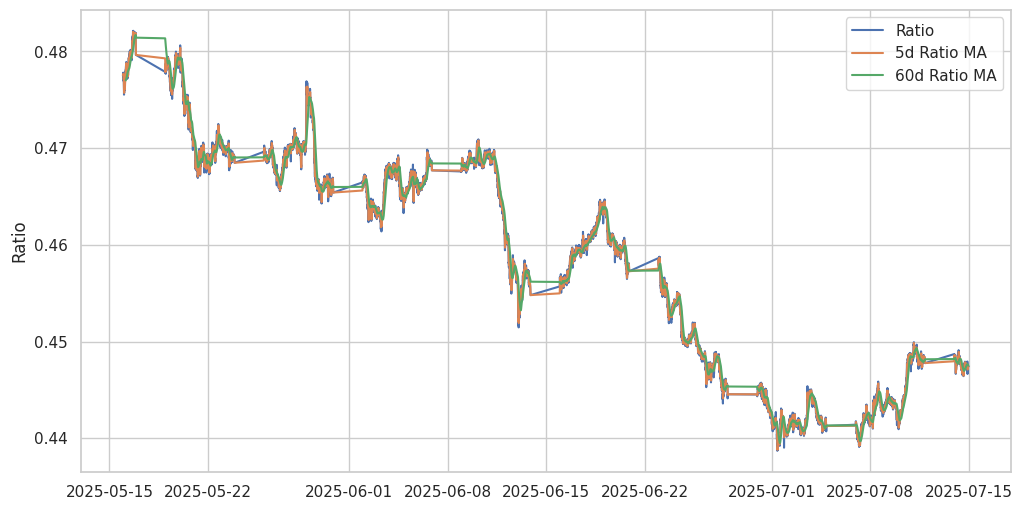

In [32]:
ratios_mavg5 = train.rolling(window=5, center=False).mean()
ratios_mavg60 = train.rolling(window=60, center=False).mean()
std_60 = train.rolling(window=60, center=False).std()
zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60
plt.figure(figsize=(12, 6))
plt.plot(train.index, train.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg60.index, ratios_mavg60.values)
plt.legend(['Ratio', '5d Ratio MA', '60d Ratio MA'])

plt.ylabel('Ratio')
plt.show()

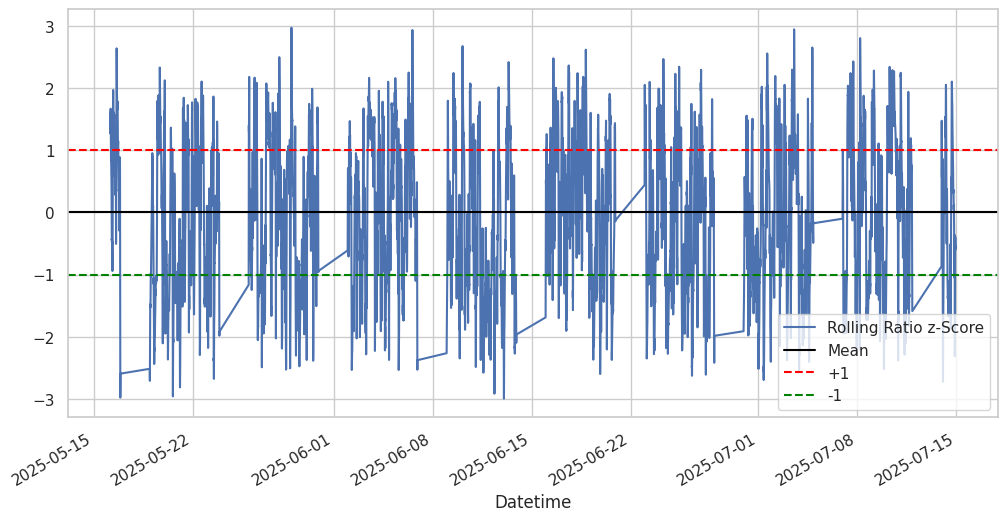

In [33]:
plt.figure(figsize=(12,6))
zscore_60_5.plot()
# plt.xlim('2019-03-25', '2023-07-01')
# plt.xlim('2025-07-06', datetime.datetime.now())
# end_date = df.index.max()
# start_date = end_date - pd.Timedelta(period)
# plt.xlim(start_date, datetime.datetime.now())
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+1', '-1'])
plt.show()

#### Creating a Model

A standard normal distribution has a mean of 0 and a standard deviation 1. Looking at the plot, it's pretty clear that if the time series moves 1 standard deviation beyond the mean, it tends to revert back towards the mean. Using these models, we can create the following trading signals:

* Buy (1) whenever the z-score is below -1, meaning we expect the ratio to increase.
* Sell (-1) whenever the z-score is above 1, meaning we expect the ratio to decrease.

Стандартное нормальное распределение имеет среднее значение 0 и стандартное отклонение 1. Глядя на график, становится ясно, что если временной ряд выходит за пределы среднего значения на 1 стандартное отклонение, то он стремится вернуться к среднему значению. Используя эти модели, мы можем создать следующие торговые сигналы:

* Покупать (1) (Buy) всякий раз, когда z-score ниже -1, что означает, что мы ожидаем увеличения коэффициента.
* Продавать (-1) (Sell), когда z-score выше 1, то есть мы ожидаем, что соотношение уменьшится.

#### Training Optimizing / Обучение Оптимизация

We can use our model on actual data

Мы можем использовать нашу модель на реальных данных.

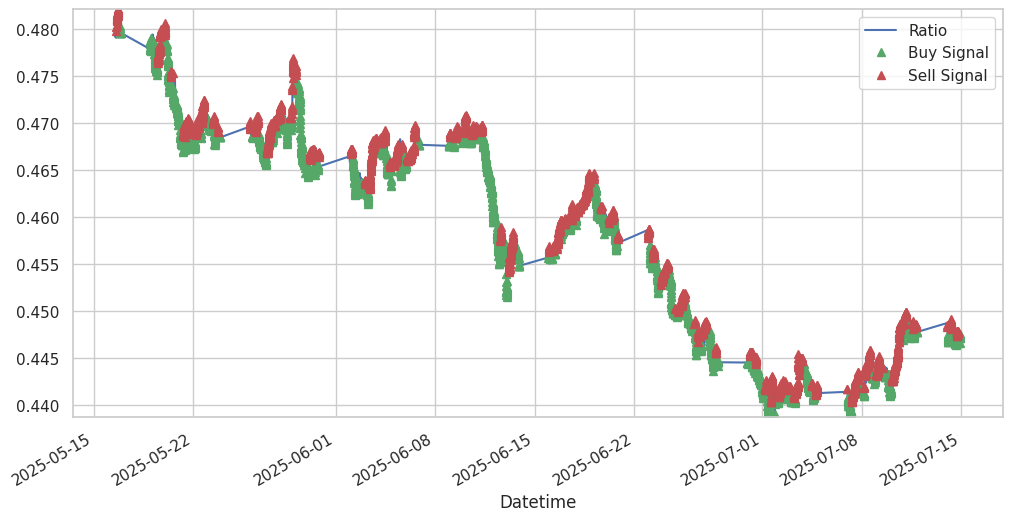

In [34]:
plt.figure(figsize=(12,6))

train[160:].plot()
buy = train.copy()
sell = train.copy()
buy[zscore_60_5>-1] = 0
sell[zscore_60_5<1] = 0
buy[160:].plot(color='g', linestyle='None', marker='^')
sell[160:].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, ratios.min(), ratios.max()))
# plt.xlim('2019-08-15','2023-07-07')
# plt.xlim('2025-07-01', datetime.datetime.now())
# plt.xlim('2025-07-01', df.index.max())
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()

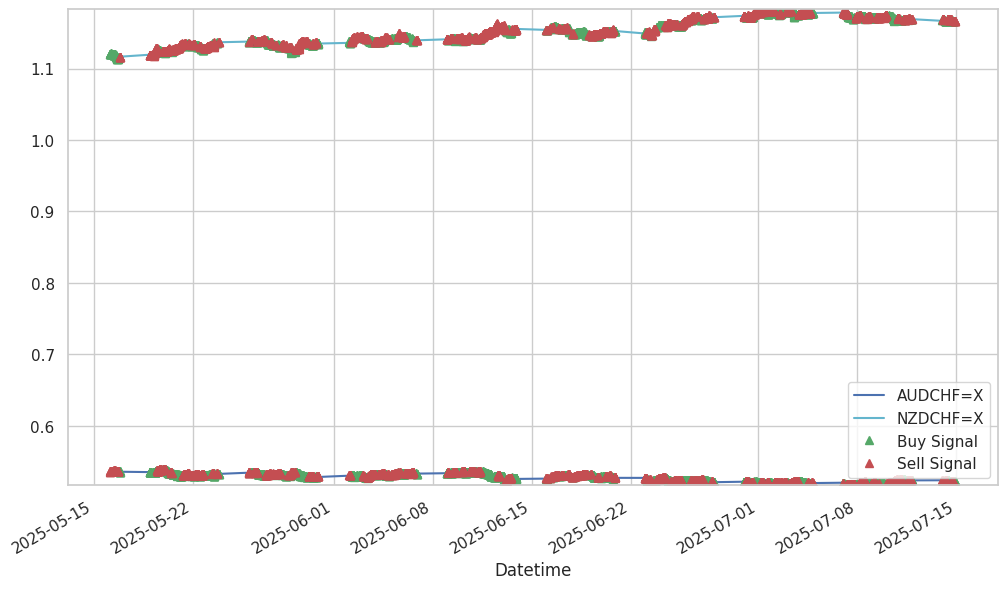

In [35]:
plt.figure(figsize=(12,7))
S1 = df[names[0]].iloc[:train_len_ratios]
S2 = df[names[1]].iloc[:train_len_ratios]
# S1 = df['AUDCHF=X'].iloc[:train_len_ratios]
# S2 = df['NZDCHF=X'].iloc[:train_len_ratios]

S1[60:].plot(color='b')
S2[60:].plot(color='c')
buyR = 0*S1.copy()
sellR = 0*S1.copy()

# When you buy the ratio, you buy stock S1 and sell S2
buyR[buy!=0] = S1[buy!=0]
sellR[buy!=0] = S2[buy!=0]

# When you sell the ratio, you sell stock S1 and buy S2
buyR[sell!=0] = S2[sell!=0]
sellR[sell!=0] = S1[sell!=0]

buyR[60:].plot(color='g', linestyle='None', marker='^')
sellR[60:].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, min(S1.min(), S2.min()), max(S1.max(), S2.max())))
# plt.ylim(25, 105)
# plt.xlim('2019-03-22', '2023-07-04')

plt.legend(['AUDCHF=X', 'NZDCHF=X', 'Buy Signal', 'Sell Signal'])
plt.show()

Now we can clearly see when we should buy or sell on the respective stocks.

Now, how much can we expect to make of this strategy?

Теперь мы четко видим, когда нам следует покупать или продавать соответствующие акции.

Итак, сколько мы можем рассчитывать заработать на этой стратегии?

In [36]:
# Trade using a simple strategy
def trade(S1, S2, window1, window2):

    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0

    # Compute rolling mean and rolling standard deviation
    ratios = S1/S2
    ma1 = ratios.rolling(window=window1,
                               center=False).mean()
    ma2 = ratios.rolling(window=window2,
                               center=False).mean()
    std = ratios.rolling(window=window2,
                        center=False).std()
    zscore = (ma1 - ma2)/std

    # Simulate trading
    # Start with no money and no positions
    money = 0
    countS1 = 0
    countS2 = 0
    for i in range(len(ratios)):
        # Sell short if the z-score is > 1
        if zscore.iloc[i] < -1:
            money += S1.iloc[i] - S2.iloc[i] * ratios.iloc[i]
            countS1 -= 1
            countS2 += ratios.iloc[i]
            #print('Selling Ratio %s %s %s %s'%(money, ratios[i], countS1,countS2))
        # Buy long if the z-score is < -1
        elif zscore.iloc[i] > 1:
            money -= S1.iloc[i] - S2.iloc[i] * ratios.iloc[i]
            countS1 += 1
            countS2 -= ratios.iloc[i]
            #print('Buying Ratio %s %s %s %s'%(money,ratios[i], countS1,countS2))
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore.iloc[i]) < 0.75:
            money += S1.iloc[i] * countS1 + S2.iloc[i] * countS2
            countS1 = 0
            countS2 = 0
            #print('Exit pos %s %s %s %s'%(money,ratios[i], countS1,countS2))


    return money

In [37]:
# result = trade(df['AUDCHF=X'].iloc[1509:], df['NZDCHF=X'].iloc[1509:], 60, 5)
result = trade(df[names[0]].iloc[train_len_ratios:], df[names[1]].iloc[train_len_ratios:], 60, 5)
print(f"{result * 100:.2f}%")

69.00%


Not a bad profit for a strategy that is made from stratch.

Неплохая прибыль для стратегии, сделанной из страта.

# **Areas of Improvement and Further Steps / Области совершенствования и дальнейшие шаги**

*This is by no means a perfect strategy and the implementation of our strategy isn't the best. However, there are several things that can be improved upon.*

Это далеко не идеальная стратегия, и реализация нашей стратегии не самая лучшая. Однако есть несколько моментов, которые можно улучшить.

### **1. Using more securities and more varied time ranges / Использование большего количества ценных бумаг и более разнообразных временных диапазонов**

For the pairs trading strategy cointegration test, I only used a handful of stocks. Naturally (and in practice) it would be more effective to use clusters within an industry. I only use the time range of only 5 years, which may not be representative of stock market volatility.

Для теста на коинтеграцию в рамках стратегии парной торговли я использовал лишь несколько акций. Естественно (и на практике) было бы эффективнее использовать кластеры внутри отрасли. Я использовал временной диапазон всего в 5 лет, что может не отражать волатильность фондового рынка.

### **2. Dealing with overfitting / Работа с избыточным подбором**

Anything related to data analysis and training models has much to do with the problem of overfitting. There are many different ways to deal with overfitting like validation, such as Kalman filters, and other statistical methods.

Все, что связано с анализом данных и обучением моделей, имеет много общего с проблемой чрезмерной подгонки. Существует множество различных способов решения проблемы перебора, таких как валидация, например фильтры Калмана, и другие статистические методы.

### **3. Adjusting the trading signals / Настройка торговых сигналов**

Our trading algorithm fails to account for stock prices that overlap and cross each other. Considering that the code only calls for a buy or sell given its ratio, it doesn't take into account which stock is actually higher or lower.

Наш торговый алгоритм не учитывает цены акций, которые перекрывают и пересекают друг друга. Учитывая, что код призывает покупать или продавать только по соотношению, он не принимает во внимание, какая акция на самом деле выше или ниже.

### **4. More advanced methods / Более продвинутые методы**

This is just the tip of the iceberg of what you can do with algorithmic pairs trading. It's simple because it only deals with moving averages and ratios. If you want to use more complicated statistics, feel free to do so. Other complex examples include subjects such as the Hurst exponent, half-life mean reversion, and Kalman Filters.

Это лишь верхушка айсберга того, что можно сделать с помощью алгоритмической торговли парами. Он прост, потому что имеет дело только со скользящими средними и коэффициентами. Если вы хотите использовать более сложную статистику, не стесняйтесь. Другие сложные примеры включают такие темы, как экспонента Херста, полупериод среднего возврата и фильтры Калмана.

# Addendum: Finding the Optimal Trading Window / Дополнение: Поиск оптимального торгового окна

We also need to give a special mention for overfitting. Overfitting is the most dangerous pitfall of a trading strategy. An overfit algorithm may peform great on a backtest but fails miserably on new unnseen data -- this means it has not really uncovered any trend in data and no real predictive power.

In our model, we used rolling parameter estimates and we may want to use an optimal window length. We may decide to simply iterate over all possible, reasonable window length and pick the length based on which our model performs the best.

Below I have written a simple loop to create window lengths based on our PnL of training data to find the best window.

Отдельно стоит упомянуть о чрезмерной подгонке. Переподгонка - это самый опасный подводный камень торговой стратегии. Алгоритм с избыточной подгонкой может показать отличные результаты на бэктесте, но потерпеть неудачу на новых неизвестных данных - это означает, что он не выявил никакой тенденции в данных и не обладает реальной предсказательной силой.

В нашей модели мы использовали скользящие оценки параметров, и мы можем захотеть использовать оптимальную длину окна. Мы можем решить просто перебрать все возможные, разумные длины окон и выбрать ту длину, при которой наша модель работает лучше всего.

Ниже я написал простой цикл для создания длины окна на основе наших PnL обучающих данных, чтобы найти оптимальное окно.

In [40]:
# Find the window length 0-254
# that gives the highest returns using this strategy
length_scores = [trade(df[names[0]].iloc[:1057],
                df[names[1]].iloc[:1057], l, 5)
                for l in range(255)]
best_length = np.argmax(length_scores)
print ('Best window length:', best_length)

Best window length: 155


As we can see, our optimal window length is from 5 days to 250 days. We can compare this with the testing data and see that this window length is far from optimal. This is because our original choice for the window length probability overfit the sample data.

Как мы видим, оптимальная длина окна составляет от 5 дней до 250 дней. Мы можем сравнить это с данными тестирования и увидеть, что эта длина окна далека от оптимальной. Это объясняется тем, что наш первоначальный выбор длины окна с большой вероятностью не соответствует данным выборки.

In [41]:
length_scores2 = [trade(df[names[0]].iloc[1057:],
                  df[names[1]].iloc[1057:],l,5)
                  for l in range(255)]
print (best_length, 'day window:', length_scores2[best_length])
# Find the best window length based on this dataset,
# and the returns using this window length
best_length2 = np.argmax(length_scores2)
print (best_length2, 'day window:', length_scores2[best_length2])

155 day window: 3.457555295258702
254 day window: 3.7387415792522916


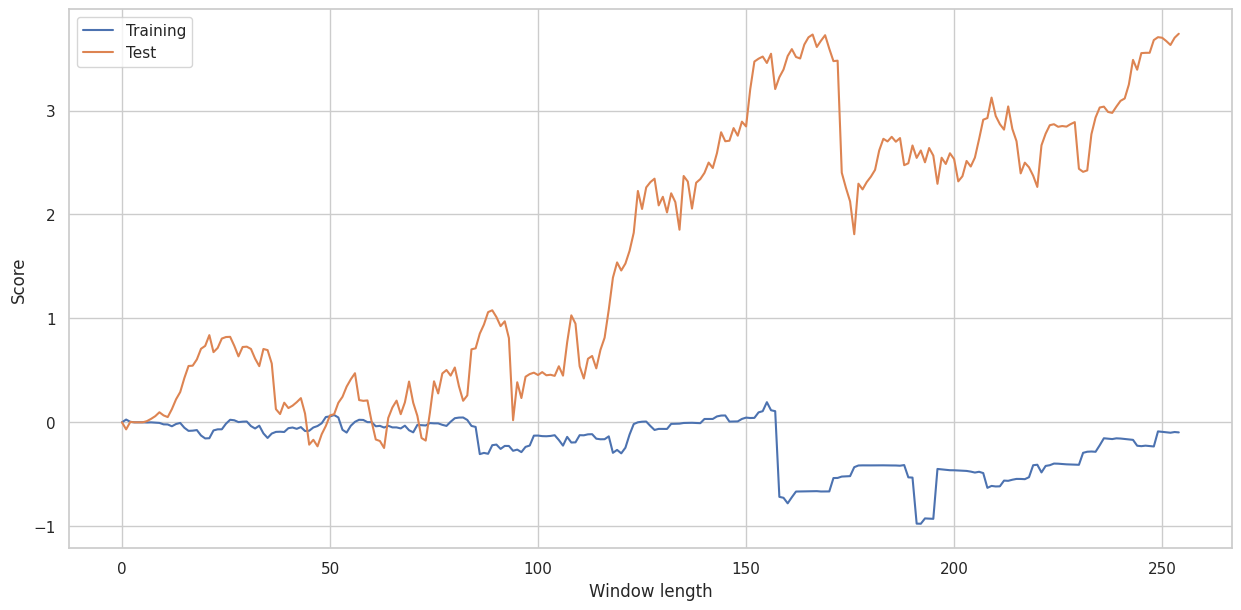

In [42]:
plt.figure(figsize=(15,7))
plt.plot(length_scores)
plt.plot(length_scores2)
plt.xlabel('Window length')
plt.ylabel('Score')
plt.legend(['Training', 'Test'])
plt.show()

So really using anything above ~50 days would be a good choice for our trading window. To avoid overfitting, we can use economic reasoning to pick our window length. We can also use other techniques such as Kalman filters, which doesn't require us to specify a length. I'll cover this later in another notebook.

Таким образом, все, что превышает ~50 дней, будет хорошим выбором для нашего торгового окна. Чтобы избежать перебора, мы можем использовать экономическое обоснование для выбора длины окна. Мы также можем использовать другие методы, такие как фильтры Калмана, которые не требуют указания длины. Я расскажу об этом позже в другом блокноте.



---





---



# Загрузка 30 дней 1m 7 дневными периодами (Sider)
- Yahoo Finance ограничивает получение данных 1m только последними 30 днями.

v0.2
- Расчет периода разбит на сегменты по 7 дней.
- Для каждого сегмента определяет интервал (1m или 1d) на основе длины диапазона.
- Загружает данные через yfinance.
- Объединяет все сегменты в один DataFrame и сортирует по времени.

In [259]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta

# Настройки
# ticker = 'NQ=F'  # Ваш тикер
tickers = ['AAPL', 'ADBE', 'ORCL', 'EBAY', 'MSFT', 'QCOM', 'HPQ', 'JNPR', 'AMD', 'IBM',
           'SPY', '^GSPC', '^SPX', '^IXIC', '^NDX', '^DJI', '^RUT', 'CL=F', 'GC=F', 'ES=F', 'NQ=F', 'QQQ', 'YM=F', 'YMAX', 'DJIA', 'IWM']
total_months = 3
segment_days = 7

# Текущая дата
today = datetime.now()

# Расчет стартовой даты (3 месяца назад)
start_day = today - pd.DateOffset(months=total_months)

# Создаем список интервалов по 7 дней
date_ranges = []
current_start = start_day

while current_start < today:
    current_end = current_start + timedelta(days=segment_days)
    # Не превышаем сегодняшний день
    if current_end > today:
        current_end = today
    date_ranges.append((current_start, current_end))
    current_start = current_end

def download_data(ticker, start, end):
    days_diff = (end - start).days
    # Выбор интервала: 1m для <=30 дней, 1d для более длинных периодов
    interval = '1m' if days_diff <= 30 else '1d'
    df = yf.download(
        tickers,
        start=start.strftime('%Y-%m-%d'),
        end=(end + timedelta(days=1)).strftime('%Y-%m-%d'),  # включительно
        interval=interval,
        auto_adjust=False,
        progress=False,
        # Иногда помогает отключить индикаторы
        prepost=False
    )['Close']
    return df

# Собираем все данные
data_frames = []

for start, end in date_ranges:
    df_segment = download_data(ticker, start, end)
    print(f"Загружено: {len(df_segment)} строк за {start.date()} - {end.date()} с интервалом { '1m' if (end-start).days <= 30 else '1d' }")
    data_frames.append(df_segment)

# Объединяем все DataFrame
full_data = pd.concat(data_frames)

# Удаляем дубликаты и сортируем
full_data = full_data[~full_data.index.duplicated()]
full_data = full_data.sort_index()

# Проверка
print(f"Общий объем данных: {len(full_data)} строк")
print(full_data.head())

# Теперь full_data содержит все данные за 3 месяца, разделённые на сегменты по 7 дней
# Можете строить графики или сохранять


ERROR:yfinance:
26 Failed downloads:
ERROR:yfinance:['IBM', 'YMAX', 'GC=F', 'QQQ', 'CL=F', 'JNPR', 'SPY', 'EBAY', 'AMD', 'QCOM', 'NQ=F', 'IWM', 'ES=F', 'MSFT', '^SPX', 'AAPL', 'ORCL', '^IXIC', 'YM=F', 'DJIA', '^NDX', '^RUT', '^GSPC', 'HPQ', '^DJI', 'ADBE']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-05-07 -> 2025-05-15) (Yahoo error = "1m data not available for startTime=1746590400 and endTime=1747281600. The requested range must be within the last 30 days.")')


Загружено: 0 строк за 2025-05-07 - 2025-05-14 с интервалом 1m


ERROR:yfinance:
26 Failed downloads:
ERROR:yfinance:['YMAX', 'IBM', 'QQQ', 'GC=F', 'JNPR', 'CL=F', 'SPY', 'EBAY', 'QCOM', 'AMD', 'NQ=F', 'ES=F', 'IWM', 'MSFT', 'AAPL', '^SPX', 'YM=F', 'ORCL', '^IXIC', 'DJIA', '^NDX', 'ADBE', '^GSPC', '^RUT', '^DJI', 'HPQ']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-05-14 -> 2025-05-22) (Yahoo error = "1m data not available for startTime=1747195200 and endTime=1747886400. The requested range must be within the last 30 days.")')


Загружено: 0 строк за 2025-05-14 - 2025-05-21 с интервалом 1m


ERROR:yfinance:
26 Failed downloads:
ERROR:yfinance:['YMAX', 'IBM', 'GC=F', 'QQQ', 'JNPR', 'CL=F', 'SPY', 'EBAY', 'AMD', 'QCOM', 'ES=F', 'NQ=F', 'IWM', 'MSFT', 'AAPL', '^SPX', 'ORCL', 'YM=F', '^IXIC', 'DJIA', '^NDX', '^RUT', '^GSPC', 'HPQ', '^DJI', 'ADBE']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-05-21 -> 2025-05-29) (Yahoo error = "1m data not available for startTime=1747800000 and endTime=1748491200. The requested range must be within the last 30 days.")')


Загружено: 0 строк за 2025-05-21 - 2025-05-28 с интервалом 1m


ERROR:yfinance:
26 Failed downloads:
ERROR:yfinance:['YMAX', 'GC=F', 'QQQ', 'JNPR', 'CL=F', 'IBM', 'SPY', 'EBAY', 'AMD', 'QCOM', 'ES=F', 'NQ=F', 'MSFT', 'IWM', '^SPX', 'AAPL', 'ORCL', 'YM=F', 'DJIA', '^IXIC', 'ADBE', '^NDX', '^GSPC', '^RUT', 'HPQ', '^DJI']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-05-28 -> 2025-06-05) (Yahoo error = "1m data not available for startTime=1748404800 and endTime=1749096000. The requested range must be within the last 30 days.")')


Загружено: 0 строк за 2025-05-28 - 2025-06-04 с интервалом 1m


ERROR:yfinance:
26 Failed downloads:
ERROR:yfinance:['IBM', 'YMAX', 'QQQ', 'GC=F', 'CL=F', 'JNPR', 'SPY', 'EBAY', 'AMD', 'QCOM', 'ES=F', 'NQ=F', 'MSFT', 'IWM', 'AAPL', '^SPX', 'YM=F', 'ORCL', '^IXIC', 'DJIA', '^NDX', '^RUT', '^GSPC', 'HPQ', '^DJI', 'ADBE']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-06-04 -> 2025-06-12) (Yahoo error = "1m data not available for startTime=1749009600 and endTime=1749700800. The requested range must be within the last 30 days.")')


Загружено: 0 строк за 2025-06-04 - 2025-06-11 с интервалом 1m


ERROR:yfinance:
26 Failed downloads:
ERROR:yfinance:['YMAX', 'GC=F', 'QQQ', 'JNPR', 'CL=F', 'SPY', 'EBAY', 'IBM', 'AMD', 'QCOM', 'ES=F', 'NQ=F', 'MSFT', 'IWM', 'AAPL', '^SPX', 'YM=F', 'ORCL', '^IXIC', 'DJIA', 'ADBE', '^RUT', '^GSPC', 'HPQ', '^NDX', '^DJI']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-06-11 -> 2025-06-19) (Yahoo error = "1m data not available for startTime=1749614400 and endTime=1750305600. The requested range must be within the last 30 days.")')


Загружено: 0 строк за 2025-06-11 - 2025-06-18 с интервалом 1m


ERROR:yfinance:
26 Failed downloads:
ERROR:yfinance:['YMAX', 'GC=F', 'QQQ', 'JNPR', 'IBM', 'SPY', 'CL=F', 'AMD', 'EBAY', 'ES=F', 'QCOM', 'NQ=F', 'IWM', 'MSFT', '^SPX', 'YM=F', 'AAPL', '^IXIC', 'ORCL', 'DJIA', '^NDX', 'ADBE', '^RUT', '^GSPC', 'HPQ', '^DJI']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-06-18 -> 2025-06-26) (Yahoo error = "1m data not available for startTime=1750219200 and endTime=1750910400. The requested range must be within the last 30 days.")')


Загружено: 0 строк за 2025-06-18 - 2025-06-25 с интервалом 1m


ERROR:yfinance:
26 Failed downloads:
ERROR:yfinance:['IBM', 'YMAX', 'GC=F', 'JNPR', 'CL=F', 'SPY', 'EBAY', 'AMD', 'QCOM', 'ES=F', 'QQQ', 'NQ=F', 'IWM', 'MSFT', 'AAPL', 'YM=F', '^SPX', '^IXIC', 'ORCL', '^NDX', 'DJIA', 'ADBE', '^RUT', '^GSPC', 'HPQ', '^DJI']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-06-25 -> 2025-07-03) (Yahoo error = "1m data not available for startTime=1750824000 and endTime=1751515200. The requested range must be within the last 30 days.")')


Загружено: 0 строк за 2025-06-25 - 2025-07-02 с интервалом 1m


ERROR:yfinance:
26 Failed downloads:
ERROR:yfinance:['IBM', 'GC=F', 'YMAX', 'JNPR', 'QQQ', 'CL=F', 'EBAY', 'SPY', 'QCOM', 'AMD', 'NQ=F', 'ES=F', 'IWM', 'MSFT', 'AAPL', '^SPX', 'ORCL', 'YM=F', 'DJIA', '^IXIC', 'ADBE', '^NDX', '^GSPC', '^RUT', 'HPQ', '^DJI']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-07-02 -> 2025-07-10) (Yahoo error = "1m data not available for startTime=1751428800 and endTime=1752120000. The requested range must be within the last 30 days.")')


Загружено: 0 строк за 2025-07-02 - 2025-07-09 с интервалом 1m


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['JNPR']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-07-09 -> 2025-07-17)')


Загружено: 7905 строк за 2025-07-09 - 2025-07-16 с интервалом 1m


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['JNPR']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-07-16 -> 2025-07-24)')


Загружено: 7907 строк за 2025-07-16 - 2025-07-23 с интервалом 1m


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['JNPR']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-07-23 -> 2025-07-31)')


Загружено: 8077 строк за 2025-07-23 - 2025-07-30 с интервалом 1m


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['JNPR']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-07-30 -> 2025-08-07)')


Загружено: 8245 строк за 2025-07-30 - 2025-08-06 с интервалом 1m


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['JNPR']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-08-06 -> 2025-08-08)')


Загружено: 2273 строк за 2025-08-06 - 2025-08-07 с интервалом 1m
Общий объем данных: 28908 строк
Ticker                     AAPL  ADBE  AMD       CL=F  DJIA  EBAY  ES=F  \
2025-07-09 04:00:00+00:00   NaN   NaN  NaN  68.239998   NaN   NaN   NaN   
2025-07-09 04:01:00+00:00   NaN   NaN  NaN  68.239998   NaN   NaN   NaN   
2025-07-09 04:02:00+00:00   NaN   NaN  NaN  68.239998   NaN   NaN   NaN   
2025-07-09 04:03:00+00:00   NaN   NaN  NaN  68.220001   NaN   NaN   NaN   
2025-07-09 04:04:00+00:00   NaN   NaN  NaN  68.230003   NaN   NaN   NaN   

Ticker                            GC=F  HPQ  IBM  ...  QQQ  SPY     YM=F  \
2025-07-09 04:00:00+00:00  3300.699951  NaN  NaN  ...  NaN  NaN  44459.0   
2025-07-09 04:01:00+00:00  3301.699951  NaN  NaN  ...  NaN  NaN  44467.0   
2025-07-09 04:02:00+00:00  3300.600098  NaN  NaN  ...  NaN  NaN  44464.0   
2025-07-09 04:03:00+00:00  3300.100098  NaN  NaN  ...  NaN  NaN      NaN   
2025-07-09 04:04:00+00:00  3301.199951  NaN  NaN  ...  NaN  NaN      NaN

v0.1

In [255]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta

# Настройка
ticker = 'NQ=F'  # Ваш символ
today = datetime.now()

# Параметры периода
total_months = 3
interval_days = 7

# Расчет дат
end_date = today
start_date = end_date - pd.DateOffset(months=total_months)

# Создаем список начальных дат по 7-дневным интервалам
date_ranges = []
current_start = start_date

while current_start < end_date:
    current_end = current_start + timedelta(days=interval_days)
    if current_end > end_date:
        current_end = end_date
    date_ranges.append((current_start, current_end))
    current_start = current_end

# Загружаем и объединяем данные
dfs = []

for start, end in date_ranges:
    df = yf.download(
        ticker,
        start=start.strftime('%Y-%m-%d'),
        end=end.strftime('%Y-%m-%d'),
        interval='1m',
        progress=False,
        auto_adjust=False
    )['Close']
    print(f"{start} - {end}: {len(df)} rows")
    dfs.append(df)

# yfinance исключает день end.
# Например, если хотите включить полностью текущий день, добавьте end + timedelta(days=1).

# Объединяем все DataFrame
full_df = pd.concat(dfs)

# Удаляем дубликаты, если есть
full_df = full_df[~full_df.index.duplicated()]

# Сортируем по дате
full_df = full_df.sort_index()

# Теперь full_df содержит данные за 3 месяца разбитыми по 7-дневным сегментам
print(full_df)

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['NQ=F']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-05-07 -> 2025-05-14) (Yahoo error = "1m data not available for startTime=1746590400 and endTime=1747195200. The requested range must be within the last 30 days.")')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['NQ=F']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-05-14 -> 2025-05-21) (Yahoo error = "1m data not available for startTime=1747195200 and endTime=1747800000. The requested range must be within the last 30 days.")')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['NQ=F']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-05-21 -> 2025-05-28) (Yahoo error = "1m data not available for startTime=1747800000 and endTime=1748404800. The requested range must be within the last 30 days.")')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['NQ=F']: YFPricesMissingError('possibly delisted; no price da

2025-05-07 18:52:57.869101 - 2025-05-14 18:52:57.869101: 0 rows
2025-05-14 18:52:57.869101 - 2025-05-21 18:52:57.869101: 0 rows
2025-05-21 18:52:57.869101 - 2025-05-28 18:52:57.869101: 0 rows
2025-05-28 18:52:57.869101 - 2025-06-04 18:52:57.869101: 0 rows
2025-06-04 18:52:57.869101 - 2025-06-11 18:52:57.869101: 0 rows
2025-06-11 18:52:57.869101 - 2025-06-18 18:52:57.869101: 0 rows
2025-06-18 18:52:57.869101 - 2025-06-25 18:52:57.869101: 0 rows
2025-06-25 18:52:57.869101 - 2025-07-02 18:52:57.869101: 0 rows
2025-07-02 18:52:57.869101 - 2025-07-09 18:52:57.869101: 0 rows
2025-07-09 18:52:57.869101 - 2025-07-16 18:52:57.869101: 6485 rows
2025-07-16 18:52:57.869101 - 2025-07-23 18:52:57.869101: 6490 rows
2025-07-23 18:52:57.869101 - 2025-07-30 18:52:57.869101: 6621 rows
2025-07-30 18:52:57.869101 - 2025-08-06 18:52:57.869101: 6802 rows
2025-08-06 18:52:57.869101 - 2025-08-07 18:52:57.869101: 1361 rows
Ticker                         NQ=F
2025-07-09 04:09:00+00:00  22874.50
2025-07-09 04:10: